# Polars Workshop

PyCon 2025

Matt Harrison

In [1]:
import polars as pl 
pl.__version__

'1.29.0'

In [2]:
# note, I'm adding the final columns in the tweak_strava function
calc_id = (pl.col('filename')
              .str.split('/')
              .list.get(-1)
              .str.replace('.gpx', '')
              .cast(pl.Int64)
             )
calc_elapsed = (
    (pl.col("time") - pl.col("time").min())
    .dt.total_seconds()
    .over(pl.col('id'))
)

float_cols = ['distance_2d', 'latitude', 'longitude', 'elevation', 'speed_between']
cat_cols = ['name', 'type', 'filename']
cols = ['course', 'distance_2d', 'latitude', 'longitude', 'time', 'elevation',
            'speed_between', 'name', 'type', 'filename']
# drop course because it is all null
final_cols = ['distance_2d', 'latitude', 'longitude', 'time', 'elevation', 'speed_between',
    'name', 'type', 'filename', 'id', 'elapsed', 'period']

def tweak_strava(df):
    return (df
        .select(cols) # checking input
        .with_columns(id=calc_id)
        .with_columns(
            pl.col(float_cols).cast(pl.Float32),
            pl.col(cat_cols).cast(pl.Categorical),
            elapsed=calc_elapsed.cast(pl.Int32),
            time=pl.col('time').dt.convert_time_zone('America/Denver')
        )
        .with_columns(period=(pl.col('time')-pl.col('time').first()).over(pl.col('id')))
        .select(final_cols) # checking output
    )

raw = pl.read_parquet('data/bikeski.parquet')
tweak_strava(raw).columns

['distance_2d',
 'latitude',
 'longitude',
 'time',
 'elevation',
 'speed_between',
 'name',
 'type',
 'filename',
 'id',
 'elapsed',
 'period']

## Getting Data

If you threaten to delete your Strava account, they will let you download all your data [^1]

[^1]: https://support.strava.com/hc/en-us/articles/216918437-Exporting-your-Data-and-Bulk-Export

In [3]:
import polars as pl
import gpxpy
import numpy as np

def gpx_to_polars(fname):
    # Parse the GPX file
    data = gpxpy.parse(open(fname))
    prev = None
    data_dict = {'course': [],
                 'distance_2d': [],
                 'latitude': [],
                 'longitude': [],
                 'time': [],
                 'elevation': [],
                 'speed_between': [],
                }
    name = None
    type_ = None
    filename = fname
    
    # Iterate through tracks, segments, and points
    for track in data.tracks:
        if name is None:
            name = track.name
            type_ = track.type

        for seg in track.segments:
            for i, pt in enumerate(seg.points):
                if prev is None:
                    prev = pt
                for key in data_dict:
                    attr = getattr(pt, key)
                    if callable(attr):
                        data_dict[key].append(attr(prev))
                    else:
                        data_dict[key].append(attr)
                prev = pt
    data_dict['name'] = [name] * len(data_dict['course'])
    data_dict['type'] = [type_] * len(data_dict['course'])
    data_dict['filename'] = [filename] * len(data_dict['course'])
    # Create a Polars DataFrame
    df = (pl.DataFrame(data_dict)
    )
    return df
    (df
        #.with_columns([pl.col("time").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%SZ", strict=False)])
        .with_columns(
            travelled= pl.col("distance_2d").cum_sum(),
            elapsed=(pl.col("time") - pl.col("time").min()).dt.total_seconds()
        )
        .with_columns(        
            avg_velocity=pl.col("travelled") / pl.col("elapsed"),
            rolling_travelled=pl.col("travelled").rolling_mean(window_size=5),
            rolling_elapsed=pl.col("elapsed").rolling_mean(window_size=5),
        )
        .with_columns(
            rolling_velocity=pl.col("rolling_travelled") / pl.col("rolling_elapsed"),
            rolling_between=pl.col("speed_between").rolling_mean(window_size=5),
        )
    )

    return df

# Example usage:
#crash_gpx = gpxpy.parse(open('/Users/matt/Downloads/Face_plant.gpx'))




## Load Data

In [4]:
import polars as pl
import polars.selectors as cs #used to select columns 
#raw = pl.read_parquet('data/activities.parquet')
raw = pl.read_parquet('data/bikeski.parquet')
print(raw)

shape: (3_446_002, 10)
┌────────┬────────────┬───────────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ course ┆ distance_2 ┆ latitude  ┆ longitude  ┆ … ┆ speed_bet ┆ name      ┆ type      ┆ filename  │
│ ---    ┆ d          ┆ ---       ┆ ---        ┆   ┆ ween      ┆ ---       ┆ ---       ┆ ---       │
│ null   ┆ ---        ┆ f64       ┆ f64        ┆   ┆ ---       ┆ str       ┆ str       ┆ str       │
│        ┆ f64        ┆           ┆            ┆   ┆ f64       ┆           ┆           ┆           │
╞════════╪════════════╪═══════════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ null   ┆ 0.0        ┆ 41.370804 ┆ -111.90177 ┆ … ┆ null      ┆ 365 and   ┆ ebikeride ┆ data/acti │
│        ┆            ┆           ┆ 2          ┆   ┆           ┆ spork     ┆           ┆ vities/11 │
│        ┆            ┆           ┆            ┆   ┆           ┆           ┆           ┆ 769838026 │
│        ┆            ┆           ┆            ┆   ┆           ┆    

### Exercise

- Load the data above.
- Inspect the `.shape` attribute of the data

In [5]:
raw.shape

(3446002, 10)

## Types

In [6]:
print(raw.columns)

['course', 'distance_2d', 'latitude', 'longitude', 'time', 'elevation', 'speed_between', 'name', 'type', 'filename']


In [7]:
cols = ['course', 'distance_2d', 'latitude', 'longitude', 'time', 'elevation',
         'speed_between', 'name', 'type', 'filename']
raw[cols].dtypes

[Null,
 Float64,
 Float64,
 Float64,
 Datetime(time_unit='us', time_zone='UTC'),
 Float64,
 Float64,
 String,
 String,
 String]

In [8]:
# 345 MB
raw[cols].estimated_size()

345179167

# pandas 
needs memory, 
does not have a query engine, naive 


# polars 
can load data that goes beyond memory (especially with lazy mode), you cannot simply replace pandas by polars in the syntax.
has a query engine (process data more smartly)  


# Comparison between Pandas and Polars
| Feature        | **Pandas**                 | **Polars**                                 |
| -------------- | -------------------------- | ------------------------------------------ |
| Backend        | Pure Python (C extensions) | Rust backend with Python bindings          |
| Lazy execution | ❌ No                       | ✅ Yes (like Spark)                         |
| Multithreading | ❌ Mostly single-threaded   | ✅ Fully multithreaded                      |
| Memory usage   | Higher                     | Lower and more efficient                   |
| Speed          | Slower for large data      | Much faster (especially on large datasets) |


# Comparison between Polars and PySpark
| Feature                        | **Polars**                                      | **PySpark**                                |
| ------------------------------ | ----------------------------------------------- | ------------------------------------------ |
| **Backend Language**           | Rust                                            | Scala/Java (with Python API)               |
| **Execution Model**            | Eager + Lazy                                    | Lazy (DataFrame, RDD APIs)                 |
| **Parallelism**                | Multithreaded (single machine)                  | Distributed (across a cluster)             |
| **Performance**                | ⚡ Extremely fast (in-memory)                    | 🚀 Scales horizontally but higher overhead |
| **Data Size Limit**            | Limited by machine RAM                          | Scales to petabytes across many nodes      |
| **Startup Time**               | Low (milliseconds)                              | High (JVM startup, context initialization) |
| **Ease of Use**                | Simple API, fast install                        | Requires Spark installation + setup        |
| **Best Use Case**              | Local, large-but-fittable datasets              | Massive, distributed datasets              |
| **Out-of-Core Support**        | Limited (experimental)                          | ✅ Built-in via Spark engine                |
| **Cloud/Big Data Integration** | ❌ Limited                                       | ✅ Strong (S3, Hive, Delta Lake, etc.)      |
| **Ecosystem Maturity**         | Growing                                         | Very mature (Databricks, EMR, etc.)        |
| **Machine Learning**           | Via Python libs (e.g., sklearn)                 | MLlib (basic, mostly Scala-focused)        |
| **Typical Language**           | Python                                          | Python (API), Scala (backend)              |
| **Use Case Example**           | Fast local feature engineering / CSV processing | ETL pipelines on large cloud data lakes    |



# Difference between multithreaded and distributed  
| Feature               | **Multithreaded**                                | **Distributed**                                      |
| --------------------- | ------------------------------------------------ | ---------------------------------------------------- |
| **Runs on**           | A **single machine**, using multiple CPU threads | **Multiple machines (nodes)** over a network         |
| **Parallelism model** | Shared-memory parallelism (threads)              | Message-passing parallelism (nodes talk via network) |
| **Speed-up type**     | Utilizes **all CPU cores** on one machine        | Utilizes **many machines** working in parallel       |
| **Overhead**          | Low (shared memory, no network)                  | Higher (network, data serialization, coordination)   |
| **Typical tool**      | **Polars**, NumPy, Pandas + joblib/dask          | **PySpark**, Hadoop, Dask (distributed mode)         |
| **Data limit**        | Bound by the RAM/CPU of one machine              | Scales across cluster (can handle petabytes)         |
| **Fault tolerance**   | ❌ Limited (crash = job fails)                    | ✅ Built-in (nodes can fail & recover)                |


## Ints

In [9]:
# add a id from the filename
print(raw
 .select(cols)
 .with_columns(id=pl.col('filename')
               .str.split('/')
               .list.get(-1)
               .str.replace('.gpx', '')
               .cast(pl.Int64)
               )
)

shape: (3_446_002, 11)
┌────────┬────────────┬───────────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ course ┆ distance_2 ┆ latitude  ┆ longitude  ┆ … ┆ name      ┆ type      ┆ filename  ┆ id        │
│ ---    ┆ d          ┆ ---       ┆ ---        ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ null   ┆ ---        ┆ f64       ┆ f64        ┆   ┆ str       ┆ str       ┆ str       ┆ i64       │
│        ┆ f64        ┆           ┆            ┆   ┆           ┆           ┆           ┆           │
╞════════╪════════════╪═══════════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ null   ┆ 0.0        ┆ 41.370804 ┆ -111.90177 ┆ … ┆ 365 and   ┆ ebikeride ┆ data/acti ┆ 117698380 │
│        ┆            ┆           ┆ 2          ┆   ┆ spork     ┆           ┆ vities/11 ┆ 26        │
│        ┆            ┆           ┆            ┆   ┆           ┆           ┆ 769838026 ┆           │
│        ┆            ┆           ┆            ┆   ┆           ┆    

In [10]:
raw['filename'].head()[1]

'data/activities/11769838026.gpx'

In [11]:
# add an elapsed column to each activity
# add a id from the filename

calc_id = (pl.col('filename')
              .str.split('/')
              .list.get(-1)
              .str.replace('.gpx', '')
              .cast(pl.Int64)
             )

(raw
 .select(cols)
 .with_columns(id=calc_id)
)

course,distance_2d,latitude,longitude,time,elevation,speed_between,name,type,filename,id
null,f64,f64,f64,"datetime[μs, UTC]",f64,f64,str,str,str,i64
null,0.0,41.370804,-111.901772,2024-06-29 16:54:56 UTC,1713.0,null,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026
null,6.704555,41.370844,-111.901712,2024-06-29 16:54:57 UTC,1712.9,6.705301,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026
null,4.160126,41.370807,-111.901719,2024-06-29 16:54:58 UTC,1712.8,4.161328,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026
null,2.62628,41.370784,-111.901726,2024-06-29 16:54:59 UTC,1712.8,2.62628,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026
null,1.26929,41.370773,-111.90173,2024-06-29 16:55:00 UTC,1712.7,1.273223,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026
…,…,…,…,…,…,…,…,…,…,…
null,0.0,40.747424,-111.562045,2021-07-09 01:52:18 UTC,1918.4,0.0,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888
null,0.139658,40.747425,-111.562046,2021-07-09 01:52:19 UTC,1918.4,0.139658,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888
null,0.084335,40.747425,-111.562047,2021-07-09 01:52:20 UTC,1918.4,0.084335,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888


In [12]:
(raw
 .select(cols)
 .with_columns(id=calc_id)
)['filename'].head()[1]

'data/activities/11769838026.gpx'

In [13]:
# add an elapsed column to each activity
# add a id from the filename

calc_id = (pl.col('filename')
              .str.split('/')
              .list.get(-1)
              .str.replace('.gpx', '')
              .cast(pl.Int64)
             )
calc_elapsed = (
    (pl.col("time") - pl.col("time").min())
    .dt.total_seconds()
    .over(pl.col('id'))
)

(raw
 .select(cols)
 .with_columns(id=calc_id)
 # needs to be in its own with_columns because we reference id
 .with_columns(elapsed=calc_elapsed)
)

course,distance_2d,latitude,longitude,time,elevation,speed_between,name,type,filename,id,elapsed
null,f64,f64,f64,"datetime[μs, UTC]",f64,f64,str,str,str,i64,i64
null,0.0,41.370804,-111.901772,2024-06-29 16:54:56 UTC,1713.0,null,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,0
null,6.704555,41.370844,-111.901712,2024-06-29 16:54:57 UTC,1712.9,6.705301,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,1
null,4.160126,41.370807,-111.901719,2024-06-29 16:54:58 UTC,1712.8,4.161328,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,2
null,2.62628,41.370784,-111.901726,2024-06-29 16:54:59 UTC,1712.8,2.62628,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,3
null,1.26929,41.370773,-111.90173,2024-06-29 16:55:00 UTC,1712.7,1.273223,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,4
…,…,…,…,…,…,…,…,…,…,…,…
null,0.0,40.747424,-111.562045,2021-07-09 01:52:18 UTC,1918.4,0.0,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888,6804
null,0.139658,40.747425,-111.562046,2021-07-09 01:52:19 UTC,1918.4,0.139658,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888,6805
null,0.084335,40.747425,-111.562047,2021-07-09 01:52:20 UTC,1918.4,0.084335,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888,6806


In [14]:
# cast ints to int16
calc_id = (pl.col('filename')
              .str.split('/')
              .list.get(-1)
              .str.replace('.gpx', '')
              .cast(pl.Int64)
             )
calc_elapsed = (
    (pl.col("time") - pl.col("time").min())
    .dt.total_seconds()
    .over(pl.col('id'))
)

(raw
 .select(cols)
 .with_columns(id=calc_id) # make an id because polars is multicore and need to provide a column for multicore 
 # needs to be in its own with_columns because we reference id
 .with_columns(elapsed=calc_elapsed) #create a column, elapsed. 
)

course,distance_2d,latitude,longitude,time,elevation,speed_between,name,type,filename,id,elapsed
null,f64,f64,f64,"datetime[μs, UTC]",f64,f64,str,str,str,i64,i64
null,0.0,41.370804,-111.901772,2024-06-29 16:54:56 UTC,1713.0,null,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,0
null,6.704555,41.370844,-111.901712,2024-06-29 16:54:57 UTC,1712.9,6.705301,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,1
null,4.160126,41.370807,-111.901719,2024-06-29 16:54:58 UTC,1712.8,4.161328,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,2
null,2.62628,41.370784,-111.901726,2024-06-29 16:54:59 UTC,1712.8,2.62628,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,3
null,1.26929,41.370773,-111.90173,2024-06-29 16:55:00 UTC,1712.7,1.273223,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,4
…,…,…,…,…,…,…,…,…,…,…,…
null,0.0,40.747424,-111.562045,2021-07-09 01:52:18 UTC,1918.4,0.0,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888,6804
null,0.139658,40.747425,-111.562046,2021-07-09 01:52:19 UTC,1918.4,0.139658,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888,6805
null,0.084335,40.747425,-111.562047,2021-07-09 01:52:20 UTC,1918.4,0.084335,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888,6806


In [15]:
# describe

calc_id = (pl.col('filename')
              .str.split('/')
              .list.get(-1)
              .str.replace('.gpx', '')
              .cast(pl.Int64)
             )
calc_elapsed = (
    (pl.col("time") - pl.col("time").min())
    .dt.total_seconds()
    .over(pl.col('id'))
)

(raw
 .select(cols)
 .with_columns(id=calc_id)
 # needs to be in its own with_columns because we reference id
 .with_columns(elapsed=calc_elapsed)
 .select(cs.integer())
 .describe()
)

statistic,id,elapsed
str,f64,f64
"""count""",3.446002e6,3.446002e6
"""null_count""",0.0,0.0
"""mean""",7.8405e9,9640.301919
"""std""",3.6013e9,20015.437872
"""min""",4.87712998e8,0.0
"""25%""",4.7773e9,2338.0
"""50%""",8.4037e9,4846.0
"""75%""",1.0590e10,9035.0
"""max""",1.3480e10,165520.0


no index in polars. everything is a column in polars. null_count is the number of missing values. count is the number of non-missing values. 

In [16]:
import numpy as np
np.iinfo(np.int16)

iinfo(min=-32768, max=32767, dtype=int16)

In [17]:
import numpy as np
np.iinfo(np.int32)

iinfo(min=-2147483648, max=2147483647, dtype=int32)

In [18]:
# cast ints to int32

calc_id = (pl.col('filename')
              .str.split('/')
              .list.get(-1)
              .str.replace('.gpx', '')
              .cast(pl.Int64)
             )
calc_elapsed = (
    (pl.col("time") - pl.col("time").min())
    .dt.total_seconds()
    .over(pl.col('id'))
)

(raw
 .select(cols)
 .with_columns(id=calc_id)
 # needs to be in its own with_columns because we reference id
 .with_columns(elapsed=calc_elapsed.cast(pl.Int32))

)

course,distance_2d,latitude,longitude,time,elevation,speed_between,name,type,filename,id,elapsed
null,f64,f64,f64,"datetime[μs, UTC]",f64,f64,str,str,str,i64,i32
null,0.0,41.370804,-111.901772,2024-06-29 16:54:56 UTC,1713.0,null,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,0
null,6.704555,41.370844,-111.901712,2024-06-29 16:54:57 UTC,1712.9,6.705301,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,1
null,4.160126,41.370807,-111.901719,2024-06-29 16:54:58 UTC,1712.8,4.161328,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,2
null,2.62628,41.370784,-111.901726,2024-06-29 16:54:59 UTC,1712.8,2.62628,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,3
null,1.26929,41.370773,-111.90173,2024-06-29 16:55:00 UTC,1712.7,1.273223,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,4
…,…,…,…,…,…,…,…,…,…,…,…
null,0.0,40.747424,-111.562045,2021-07-09 01:52:18 UTC,1918.4,0.0,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888,6804
null,0.139658,40.747425,-111.562046,2021-07-09 01:52:19 UTC,1918.4,0.139658,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888,6805
null,0.084335,40.747425,-111.562047,2021-07-09 01:52:20 UTC,1918.4,0.084335,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888,6806


### : Memory Ints

- Determine how much memory is used when casting *elapsed* to an Int32

In [19]:
(raw
 .select(cols)
 .with_columns(id=calc_id)
 # needs to be in its own with_columns because we reference id
 .with_columns(elapsed=calc_elapsed.cast(pl.Int32))

).estimated_size()

386531191

## Floats


In [20]:
calc_id = (pl.col('filename')
              .str.split('/')
              .list.get(-1)
              .str.replace('.gpx', '')
              .cast(pl.Int64)
             )
calc_elapsed = (
    (pl.col("time") - pl.col("time").min())
    .dt.total_seconds()
    .over(pl.col('id'))
)

(raw
 .select(cols)
 .with_columns(id=calc_id)
 # needs to be in its own with_columns because we reference id
 .with_columns(elapsed=calc_elapsed.cast(pl.Int32))
 .select(cs.float()) # select float columns 
)

distance_2d,latitude,longitude,elevation,speed_between
f64,f64,f64,f64,f64
0.0,41.370804,-111.901772,1713.0,null
6.704555,41.370844,-111.901712,1712.9,6.705301
4.160126,41.370807,-111.901719,1712.8,4.161328
2.62628,41.370784,-111.901726,1712.8,2.62628
1.26929,41.370773,-111.90173,1712.7,1.273223
…,…,…,…,…
0.0,40.747424,-111.562045,1918.4,0.0
0.139658,40.747425,-111.562046,1918.4,0.139658
0.084335,40.747425,-111.562047,1918.4,0.084335


In [21]:
cs.float?

Signature: cs.float() -> 'SelectorType'
Docstring:
Select all float columns.

See Also
--------
integer : Select all integer columns.
numeric : Select all numeric columns.
signed_integer : Select all signed integer columns.
unsigned_integer : Select all unsigned integer columns.

Examples
--------
>>> import polars.selectors as cs
>>> df = pl.DataFrame(
...     {
...         "foo": ["x", "y"],
...         "bar": [123, 456],
...         "baz": [2.0, 5.5],
...         "zap": [0.0, 1.0],
...     },
...     schema_overrides={"baz": pl.Float32, "zap": pl.Float64},
... )

Select all float columns:

>>> df.select(cs.float())
shape: (2, 2)
┌─────┬─────┐
│ baz ┆ zap │
│ --- ┆ --- │
│ f32 ┆ f64 │
╞═════╪═════╡
│ 2.0 ┆ 0.0 │
│ 5.5 ┆ 1.0 │
└─────┴─────┘

Select all columns *except* for those that are float:

>>> df.select(~cs.float())
shape: (2, 2)
┌─────┬─────┐
│ foo ┆ bar │
│ --- ┆ --- │
│ str ┆ i64 │
╞═════╪═════╡
│ x   ┆ 123 │
│ y   ┆ 456 │
└─────┴─────┘
File:      ~/2025-pycon-polars/.venv/li

In [22]:
# cast
calc_id = (pl.col('filename')
              .str.split('/')
              .list.get(-1)
              .str.replace('.gpx', '')
              .cast(pl.Int64)
             )
calc_elapsed = (
    (pl.col("time") - pl.col("time").min())
    .dt.total_seconds()
    .over(pl.col('id'))
)

(raw
 .select(cols)
 .with_columns(id=calc_id)
 # needs to be in its own with_columns because we reference id
 .with_columns(elapsed=calc_elapsed.cast(pl.Int32))
 .select(cs.float())
 .columns
)

['distance_2d', 'latitude', 'longitude', 'elevation', 'speed_between']

### Exercise:

- How much memory is used if we cast the float columns to Float32?

In [23]:
float_cols = ['distance_2d', 'latitude', 'longitude', 'elevation', 'speed_between']
(raw
 .select(cols)
 .with_columns(id=calc_id)
 .with_columns(eplased = calc_elapsed.cast(pl.Int32))
 .with_columns(pl.col(float_cols).cast(pl.Float32))
).estimated_size()

317611120

## Strings

In [24]:

calc_id = (pl.col('filename')
              .str.split('/')
              .list.get(-1)
              .str.replace('.gpx', '')
              .cast(pl.Int64)
             )
calc_elapsed = (
    (pl.col("time") - pl.col("time").min())
    .dt.total_seconds()
    .over(pl.col('id'))
)

float_cols = ['distance_2d', 'latitude', 'longitude', 'elevation', 'speed_between']

(raw
 .select(cols)
 .with_columns(id=calc_id)
 # needs to be in its own with_columns because we reference id
 .with_columns(elapsed=calc_elapsed.cast(pl.Int32))
 .with_columns(pl.col(float_cols).cast(pl.Float32))
 .select(cs.string())
)

name,type,filename
str,str,str
"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…"
"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…"
"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…"
"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…"
"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…"
…,…,…
"""The dropout""","""cycling""","""data/activities/5597638888.gpx"""
"""The dropout""","""cycling""","""data/activities/5597638888.gpx"""
"""The dropout""","""cycling""","""data/activities/5597638888.gpx"""


In [25]:
pl.col('').str

In [26]:
dir(pl.col('').str) # all the string operations we can do for polars string 

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__firstlineno__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__static_attributes__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_accessor',
 '_pyexpr',
 'concat',
 'contains',
 'contains_any',
 'count_matches',
 'decode',
 'encode',
 'ends_with',
 'escape_regex',
 'explode',
 'extract',
 'extract_all',
 'extract_groups',
 'extract_many',
 'find',
 'find_many',
 'head',
 'join',
 'json_decode',
 'json_path_match',
 'len_bytes',
 'len_chars',
 'normalize',
 'pad_end',
 'pad_start',
 'replace',
 'replace_all',
 'replace_many',
 'reverse',
 'slice',
 'split',
 'split_exact',
 'splitn',
 'starts_with',
 'strip_chars',
 'strip_chars_end',
 'strip_chars_start',
 'strip_prefix',
 'strip_suffi

In [27]:
# cast to categorical removes 50% of the size
calc_id = (pl.col('filename')
              .str.split('/')
              .list.get(-1)
              .str.replace('.gpx', '')
              .cast(pl.Int64)
             )
calc_elapsed = (
    (pl.col("time") - pl.col("time").min())
    .dt.total_seconds()
    .over(pl.col('id'))
)

float_cols = ['distance_2d', 'latitude', 'longitude', 'elevation', 'speed_between']

(raw
 .select(cols)
 .with_columns(id=calc_id)
 # needs to be in its own with_columns because we reference id
 .with_columns(elapsed=calc_elapsed.cast(pl.Int32))
 .with_columns(pl.col(float_cols).cast(pl.Float32))
 .with_columns(cs.string().cast(pl.Categorical))
 .estimated_size()
)

179643487

In [28]:
(raw
 .select(cols)
 .with_columns(id=calc_id)
 # needs to be in its own with_columns because we reference id
 .with_columns(elapsed=calc_elapsed.cast(pl.Int32))
 .with_columns(pl.col(float_cols).cast(pl.Float32))
 .with_columns(cs.string().cast(pl.Categorical))
 .select(cs.string())
).head()

shape: (0, 0)
┌┐
╞╡
└┘

In [29]:
# cast to categorical removes 50% of the size
calc_id = (pl.col('filename')
              .str.split('/')
              .list.get(-1)
              .str.replace('.gpx', '')
              .cast(pl.Int64)
             )
calc_elapsed = (
    (pl.col("time") - pl.col("time").min())
    .dt.total_seconds()
    .over(pl.col('id'))
)

float_cols = ['distance_2d', 'latitude', 'longitude', 'elevation', 'speed_between']

(raw
 .select(cols)
 # add elapsed time
 .with_columns(id=calc_id)
 # needs to be in its own with_columns because we reference id
 .with_columns(elapsed=calc_elapsed.cast(pl.Int32))
 .with_columns(pl.col(float_cols).cast(pl.Float32))
 #.with_columns(cs.string().cast(pl.Categorical))
 .select(cs.string())
 .columns
)

['name', 'type', 'filename']

In [30]:
# cast to categorical removes 50% of the size
calc_id = (pl.col('filename')
              .str.split('/')
              .list.get(-1)
              .str.replace('.gpx', '')
              .cast(pl.Int64)
             )
calc_elapsed = (
    (pl.col("time") - pl.col("time").min())
    .dt.total_seconds()
    .over(pl.col('id'))
)

float_cols = ['distance_2d', 'latitude', 'longitude', 'elevation', 'speed_between']
cat_cols = ['name', 'type', 'filename']

(raw
 .select(cols)
 .with_columns(id=calc_id)
 # needs to be in its own with_columns because we reference id
 .with_columns(
    pl.col(float_cols).cast(pl.Float32),
    pl.col(cat_cols).cast(pl.Categorical),
    elapsed=calc_elapsed.cast(pl.Int32),
 ) # all the cast can happen in parallel 
)

course,distance_2d,latitude,longitude,time,elevation,speed_between,name,type,filename,id,elapsed
null,f32,f32,f32,"datetime[μs, UTC]",f32,f32,cat,cat,cat,i64,i32
null,0.0,41.370804,-111.901772,2024-06-29 16:54:56 UTC,1713.0,null,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,0
null,6.704555,41.370846,-111.901711,2024-06-29 16:54:57 UTC,1712.900024,6.705301,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,1
null,4.160126,41.370808,-111.901718,2024-06-29 16:54:58 UTC,1712.800049,4.161328,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,2
null,2.62628,41.370785,-111.901726,2024-06-29 16:54:59 UTC,1712.800049,2.62628,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,3
null,1.26929,41.370773,-111.901733,2024-06-29 16:55:00 UTC,1712.699951,1.273223,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,4
…,…,…,…,…,…,…,…,…,…,…,…
null,0.0,40.747425,-111.562042,2021-07-09 01:52:18 UTC,1918.400024,0.0,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888,6804
null,0.139658,40.747425,-111.562042,2021-07-09 01:52:19 UTC,1918.400024,0.139658,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888,6805
null,0.084335,40.747425,-111.56205,2021-07-09 01:52:20 UTC,1918.400024,0.084335,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888,6806


In [31]:
# explore categorical capabilities
pl.col('cat').cat

In [32]:
dir(pl.col('cat').cat)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__firstlineno__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__static_attributes__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_accessor',
 '_pyexpr',
 'ends_with',
 'get_categories',
 'len_bytes',
 'len_chars',
 'slice',
 'starts_with']

### Exercise: Strings

- Write an expression to capitalize the *name* column
- Write an expression to pull off just the filename portion of the *filename* column
- Write an expression to make a string column, *act_id*, that is the IDSHORT_NAMESHORT where
 `IDSHORT` is the first 4 characters of the ID and `NAMESHORT` is the firt 4 characters of the name
- Update the *act_id* expression to convert it from a string to a category.

In [33]:
# - Write an expression to capitalize the *name* column

(raw
 .select(cols)
 .with_columns(id=calc_id)
 # needs to be in its own with_columns because we reference id
 .with_columns(
    pl.col(float_cols).cast(pl.Float32),
    pl.col(cat_cols).cast(pl.Categorical),
    elapsed=calc_elapsed.cast(pl.Int32),
    name_title=pl.col("name").cast(pl.String).str.to_titlecase()
    
 ) # all the cast can happen in parallel 

)

course,distance_2d,latitude,longitude,time,elevation,speed_between,name,type,filename,id,elapsed,name_title
null,f32,f32,f32,"datetime[μs, UTC]",f32,f32,cat,cat,cat,i64,i32,str
null,0.0,41.370804,-111.901772,2024-06-29 16:54:56 UTC,1713.0,null,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,0,"""365 And Spork"""
null,6.704555,41.370846,-111.901711,2024-06-29 16:54:57 UTC,1712.900024,6.705301,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,1,"""365 And Spork"""
null,4.160126,41.370808,-111.901718,2024-06-29 16:54:58 UTC,1712.800049,4.161328,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,2,"""365 And Spork"""
null,2.62628,41.370785,-111.901726,2024-06-29 16:54:59 UTC,1712.800049,2.62628,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,3,"""365 And Spork"""
null,1.26929,41.370773,-111.901733,2024-06-29 16:55:00 UTC,1712.699951,1.273223,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,4,"""365 And Spork"""
…,…,…,…,…,…,…,…,…,…,…,…,…
null,0.0,40.747425,-111.562042,2021-07-09 01:52:18 UTC,1918.400024,0.0,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888,6804,"""The Dropout"""
null,0.139658,40.747425,-111.562042,2021-07-09 01:52:19 UTC,1918.400024,0.139658,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888,6805,"""The Dropout"""
null,0.084335,40.747425,-111.56205,2021-07-09 01:52:20 UTC,1918.400024,0.084335,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888,6806,"""The Dropout"""


## Dates



In [34]:
# convert date to local time
calc_id = (pl.col('filename')
              .str.split('/')
              .list.get(-1)
              .str.replace('.gpx', '')
              .cast(pl.Int64)
             )
calc_elapsed = (
    (pl.col("time") - pl.col("time").min())
    .dt.total_seconds()
    .over(pl.col('id'))
)

float_cols = ['distance_2d', 'latitude', 'longitude', 'elevation', 'speed_between']
cat_cols = ['name', 'type', 'filename']

(raw
 .select(cols)
 .with_columns(id=calc_id)
 # needs to be in its own with_columns because we reference id
 .with_columns(
    pl.col(float_cols).cast(pl.Float32),
    pl.col(cat_cols).cast(pl.Categorical),
    elapsed=calc_elapsed.cast(pl.Int32),
    time=pl.col('time').dt.convert_time_zone('America/Denver')
 )
)

course,distance_2d,latitude,longitude,time,elevation,speed_between,name,type,filename,id,elapsed
null,f32,f32,f32,"datetime[μs, America/Denver]",f32,f32,cat,cat,cat,i64,i32
null,0.0,41.370804,-111.901772,2024-06-29 10:54:56 MDT,1713.0,null,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,0
null,6.704555,41.370846,-111.901711,2024-06-29 10:54:57 MDT,1712.900024,6.705301,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,1
null,4.160126,41.370808,-111.901718,2024-06-29 10:54:58 MDT,1712.800049,4.161328,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,2
null,2.62628,41.370785,-111.901726,2024-06-29 10:54:59 MDT,1712.800049,2.62628,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,3
null,1.26929,41.370773,-111.901733,2024-06-29 10:55:00 MDT,1712.699951,1.273223,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,4
…,…,…,…,…,…,…,…,…,…,…,…
null,0.0,40.747425,-111.562042,2021-07-08 19:52:18 MDT,1918.400024,0.0,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888,6804
null,0.139658,40.747425,-111.562042,2021-07-08 19:52:19 MDT,1918.400024,0.139658,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888,6805
null,0.084335,40.747425,-111.56205,2021-07-08 19:52:20 MDT,1918.400024,0.084335,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888,6806


In [35]:
# calculate period (a time delta)
# vs elapsed which is numeric seconds
calc_id = (pl.col('filename')
              .str.split('/')
              .list.get(-1)
              .str.replace('.gpx', '')
              .cast(pl.Int64)
             )
calc_elapsed = (
    (pl.col("time") - pl.col("time").min())
    .dt.total_seconds()
    .over(pl.col('id'))
)

float_cols = ['distance_2d', 'latitude', 'longitude', 'elevation', 'speed_between']
cat_cols = ['name', 'type', 'filename']

(raw
 .select(cols)
 .with_columns(id=calc_id)
 # needs to be in its own with_columns because we reference id
 .with_columns(
    pl.col(float_cols).cast(pl.Float32),
    pl.col(cat_cols).cast(pl.Categorical),
    elapsed=calc_elapsed.cast(pl.Int32),
    time=pl.col('time').dt.convert_time_zone('America/Denver')
 )
 .with_columns(period=(pl.col('time')-pl.col('time').first()).over(pl.col('id')))

)

course,distance_2d,latitude,longitude,time,elevation,speed_between,name,type,filename,id,elapsed,period
null,f32,f32,f32,"datetime[μs, America/Denver]",f32,f32,cat,cat,cat,i64,i32,duration[μs]
null,0.0,41.370804,-111.901772,2024-06-29 10:54:56 MDT,1713.0,null,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,0,0µs
null,6.704555,41.370846,-111.901711,2024-06-29 10:54:57 MDT,1712.900024,6.705301,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,1,1s
null,4.160126,41.370808,-111.901718,2024-06-29 10:54:58 MDT,1712.800049,4.161328,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,2,2s
null,2.62628,41.370785,-111.901726,2024-06-29 10:54:59 MDT,1712.800049,2.62628,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,3,3s
null,1.26929,41.370773,-111.901733,2024-06-29 10:55:00 MDT,1712.699951,1.273223,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,4,4s
…,…,…,…,…,…,…,…,…,…,…,…,…
null,0.0,40.747425,-111.562042,2021-07-08 19:52:18 MDT,1918.400024,0.0,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888,6804,1h 53m 24s
null,0.139658,40.747425,-111.562042,2021-07-08 19:52:19 MDT,1918.400024,0.139658,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888,6805,1h 53m 25s
null,0.084335,40.747425,-111.56205,2021-07-08 19:52:20 MDT,1918.400024,0.084335,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888,6806,1h 53m 26s


In [36]:
pl.col('time').dt

In [37]:
dir(pl.col('time').dt)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__firstlineno__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__static_attributes__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_accessor',
 '_pyexpr',
 'add_business_days',
 'base_utc_offset',
 'cast_time_unit',
 'century',
 'combine',
 'convert_time_zone',
 'date',
 'datetime',
 'day',
 'dst_offset',
 'epoch',
 'hour',
 'is_business_day',
 'is_leap_year',
 'iso_year',
 'microsecond',
 'millennium',
 'millisecond',
 'minute',
 'month',
 'month_end',
 'month_start',
 'nanosecond',
 'offset_by',
 'ordinal_day',
 'quarter',
 'replace',
 'replace_time_zone',
 'round',
 'second',
 'strftime',
 'time',
 'timestamp',
 'to_string',
 'total_days',
 'total_hours',
 'total_microseconds',
 'tota

### Exercise: Dates

- Write an expression to make a *month* column derived from *time*
- Write an expression to make a *year* column derived from *time*
- Write an expression to make a *utc_time* column derived from *time* with time in UTC

In [38]:

(raw
 .select(cols)
 .with_columns(id=calc_id)
 # needs to be in its own with_columns because we reference id
 .with_columns(
    pl.col(float_cols).cast(pl.Float32),
    pl.col(cat_cols).cast(pl.Categorical),
    elapsed=calc_elapsed.cast(pl.Int32),
    time=pl.col('time').dt.convert_time_zone('America/Denver')
 )
 .with_columns(period=(pl.col('time')-pl.col('time').first()).over(pl.col('id')))
 .with_columns(month = pl.col('time').dt.month().alias("month"),
               year = pl.col('time').dt.year().alias("year"),
               utc = pl.col('time').dt.convert_time_zone('UTC')
              )
)


course,distance_2d,latitude,longitude,time,elevation,speed_between,name,type,filename,id,elapsed,period,month,year,utc
null,f32,f32,f32,"datetime[μs, America/Denver]",f32,f32,cat,cat,cat,i64,i32,duration[μs],i8,i32,"datetime[μs, UTC]"
null,0.0,41.370804,-111.901772,2024-06-29 10:54:56 MDT,1713.0,null,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,0,0µs,6,2024,2024-06-29 16:54:56 UTC
null,6.704555,41.370846,-111.901711,2024-06-29 10:54:57 MDT,1712.900024,6.705301,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,1,1s,6,2024,2024-06-29 16:54:57 UTC
null,4.160126,41.370808,-111.901718,2024-06-29 10:54:58 MDT,1712.800049,4.161328,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,2,2s,6,2024,2024-06-29 16:54:58 UTC
null,2.62628,41.370785,-111.901726,2024-06-29 10:54:59 MDT,1712.800049,2.62628,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,3,3s,6,2024,2024-06-29 16:54:59 UTC
null,1.26929,41.370773,-111.901733,2024-06-29 10:55:00 MDT,1712.699951,1.273223,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,4,4s,6,2024,2024-06-29 16:55:00 UTC
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
null,0.0,40.747425,-111.562042,2021-07-08 19:52:18 MDT,1918.400024,0.0,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888,6804,1h 53m 24s,7,2021,2021-07-09 01:52:18 UTC
null,0.139658,40.747425,-111.562042,2021-07-08 19:52:19 MDT,1918.400024,0.139658,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888,6805,1h 53m 25s,7,2021,2021-07-09 01:52:19 UTC
null,0.084335,40.747425,-111.56205,2021-07-08 19:52:20 MDT,1918.400024,0.084335,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888,6806,1h 53m 26s,7,2021,2021-07-09 01:52:20 UTC


## Missing Data
For Polars 
1. nan: not a number; 
2. null: missing values 

For pandas \
nan: missing values 

In [39]:
# where are values missing (null)?
calc_id = (pl.col('filename')
              .str.split('/')
              .list.get(-1)
              .str.replace('.gpx', '')
              .cast(pl.Int64)
             )
calc_elapsed = (
    (pl.col("time") - pl.col("time").min())
    .dt.total_seconds()
    .over(pl.col('id'))
)

float_cols = ['distance_2d', 'latitude', 'longitude', 'elevation', 'speed_between']
cat_cols = ['name', 'type', 'filename']

(raw
 .select(cols)
 .with_columns(id=calc_id)
 # needs to be in its own with_columns because we reference id
 .with_columns(
    pl.col(float_cols).cast(pl.Float32),
    pl.col(cat_cols).cast(pl.Categorical),
    elapsed=calc_elapsed.cast(pl.Int32),
    time=pl.col('time').dt.convert_time_zone('America/Denver')
 )
 .with_columns(period=(pl.col('time')-pl.col('time').first()).over(pl.col('id')))
 .null_count()
)

course,distance_2d,latitude,longitude,time,elevation,speed_between,name,type,filename,id,elapsed,period
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
3446002,0,0,0,0,0,1265,0,0,0,0,0,0


In [40]:
# which rows are they?
calc_id = (pl.col('filename')
              .str.split('/')
              .list.get(-1)
              .str.replace('.gpx', '')
              .cast(pl.Int64)
             )
calc_elapsed = (
    (pl.col("time") - pl.col("time").min())
    .dt.total_seconds()
    .over(pl.col('id'))
)

float_cols = ['distance_2d', 'latitude', 'longitude', 'elevation', 'speed_between']
cat_cols = ['name', 'type', 'filename']

(raw
 .select(cols)
 .with_columns(id=calc_id)
 # needs to be in its own with_columns because we reference id
 .with_columns(
    pl.col(float_cols).cast(pl.Float32),
    pl.col(cat_cols).cast(pl.Categorical),
    elapsed=calc_elapsed.cast(pl.Int32),
    time=pl.col('time').dt.convert_time_zone('America/Denver')
 )
 .with_columns(period=(pl.col('time')-pl.col('time').first()).over(pl.col('id')))
 #.null_count()
 .filter((pl.col('speed_between').is_null()) & (pl.col('name') == "Bar m"))
)

course,distance_2d,latitude,longitude,time,elevation,speed_between,name,type,filename,id,elapsed,period
null,f32,f32,f32,"datetime[μs, America/Denver]",f32,f32,cat,cat,cat,i64,i32,duration[μs]
null,0.0,38.651745,-109.668266,2021-11-26 13:03:10 MST,1392.300049,null,"""Bar m""","""cycling""","""data/activities/6310856608.gpx""",6310856608,0,0µs
null,0.0,38.652184,-109.668541,2021-11-28 11:50:27 MST,1392.300049,null,"""Bar m""","""cycling""","""data/activities/6319444402.gpx""",6319444402,0,0µs
null,0.0,38.651722,-109.668266,2024-11-28 13:31:51 MST,1390.900024,null,"""Bar m""","""ebikeride""","""data/activities/13005760232.gp…",13005760232,0,0µs


In [41]:
# what about nans?
calc_id = (pl.col('filename')
              .str.split('/')
              .list.get(-1)
              .str.replace('.gpx', '')
              .cast(pl.Int64)
             )
calc_elapsed = (
    (pl.col("time") - pl.col("time").min())
    .dt.total_seconds()
    .over(pl.col('id'))
)

float_cols = ['distance_2d', 'latitude', 'longitude', 'elevation', 'speed_between']
cat_cols = ['name', 'type', 'filename']

(raw
 .select(cols)
 # add elapsed time
 .with_columns(id=calc_id)
 # needs to be in its own with_columns because we reference id
 .with_columns(
    pl.col(float_cols).cast(pl.Float32),
    pl.col(cat_cols).cast(pl.Categorical),
    elapsed=calc_elapsed.cast(pl.Int32),
    time=pl.col('time').dt.convert_time_zone('America/Denver')
 )
 #.null_count()
 # no nan_count
 #.filter(pl.col('speed_between').is_null())
 .with_columns(period=(pl.col('time')-pl.col('time').first()).over(pl.col('id')))
 .select(cs.numeric().is_nan().sum())
)

distance_2d,latitude,longitude,elevation,speed_between,id,elapsed
u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0


# if then


The Python code:
```
if COND_EXPR:
    EXPR
elif COND_EXPR2:
    EXPR2
...
else:
    EXPRN
```

Is written in Polars as:
```
(pl.when(COND_EXPR)
   .then(EXPR)
.when(COND_EXPR2)
   .then(EXPR2)
... # more when's
.otherwise(EXPRN) # optional
```



In [42]:
# set speed_between to 0 when distance_2d is 0

(raw
 .select(cols)
 .with_columns(id=calc_id)
 # needs to be in its own with_columns because we reference id
 .with_columns(
    pl.col(float_cols).cast(pl.Float32),
    pl.col(cat_cols).cast(pl.Categorical),
    elapsed=calc_elapsed.cast(pl.Int32),
    time=pl.col('time').dt.convert_time_zone('America/Denver')
 )
 #.null_count()
 # no nan_count
 #.filter(pl.col('speed_between').is_null())
 .with_columns(period=(pl.col('time')-pl.col('time').first()).over(pl.col('id')))
 .with_columns(
     speed_between=pl.when(pl.col('speed_between').is_null())
         .then(0)
 )
).filter(pl.col('elapsed') ==0)


course,distance_2d,latitude,longitude,time,elevation,speed_between,name,type,filename,id,elapsed,period
null,f32,f32,f32,"datetime[μs, America/Denver]",f32,i32,cat,cat,cat,i64,i32,duration[μs]
null,0.0,41.370804,-111.901772,2024-06-29 10:54:56 MDT,1713.0,0,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,0,0µs
null,0.0,38.651745,-109.668266,2021-11-26 13:03:10 MST,1392.300049,0,"""Bar m""","""cycling""","""data/activities/6310856608.gpx""",6310856608,0,0µs
null,0.0,40.598866,-111.583801,2024-12-13 09:41:06 MST,2671.300049,0,"""Brighton 4""","""AlpineSki""","""data/activities/13109124808.gp…",13109124808,0,0µs
null,0.0,40.867287,-111.843399,2022-06-07 06:10:59 MDT,1564.199951,0,"""Morning ride""","""cycling""","""data/activities/7269902589.gpx""",7269902589,0,0µs
null,0.0,41.217247,-111.863564,2020-08-01 14:48:37 MDT,1928.599976,0,"""Sardine peak to wheeler""","""cycling""","""data/activities/3850491567.gpx""",3850491567,0,0µs
…,…,…,…,…,…,…,…,…,…,…,…,…
null,0.0,41.219177,-111.855621,2022-02-05 11:43:00 MST,1927.199951,0,"""Olivia's last stand""","""AlpineSki""","""data/activities/6637365620.gpx""",6637365620,0,0µs
null,0.0,41.214928,-111.858032,2017-02-01 09:44:31 MST,1959.400024,0,"""Snowbasin solo""","""AlpineSki""","""data/activities/851896259.gpx""",851896259,0,0µs
null,0.0,41.216167,-111.85778,2017-01-28 10:22:05 MST,1949.900024,0,"""Snowbasin no James""","""AlpineSki""","""data/activities/847514848.gpx""",847514848,0,0µs


## Create a function

In [43]:
# note, I'm adding the final columns in the tweak_strava function
calc_id = (pl.col('filename')
              .str.split('/')
              .list.get(-1)
              .str.replace('.gpx', '')
              .cast(pl.Int64)
             )
calc_elapsed = (
    (pl.col("time") - pl.col("time").min())
    .dt.total_seconds()
    .over(pl.col('id'))
)

float_cols = ['distance_2d', 'latitude', 'longitude', 'elevation', 'speed_between']
cat_cols = ['name', 'type', 'filename']
cols = ['course', 'distance_2d', 'latitude', 'longitude', 'time', 'elevation',
            'speed_between', 'name', 'type', 'filename']
# drop course because it is all null
final_cols = ['distance_2d', 'latitude', 'longitude', 'time', 'elevation', 'speed_between',
    'name', 'type', 'filename', 'id', 'elapsed', 'period']

def tweak_strava(df):
    return (df
        .select(cols) # checking input
        .with_columns(id=calc_id)
        .with_columns(
            pl.col(float_cols).cast(pl.Float32),
            pl.col(cat_cols).cast(pl.Categorical),
            elapsed=calc_elapsed.cast(pl.Int32),
            time=pl.col('time').dt.convert_time_zone('America/Denver')
        )
        .with_columns(period=(pl.col('time')-pl.col('time').first()).over(pl.col('id')))
        .select(final_cols) # checking output
    )

raw = pl.read_parquet('data/bikeski.parquet')
tweak_strava(raw).columns

['distance_2d',
 'latitude',
 'longitude',
 'time',
 'elevation',
 'speed_between',
 'name',
 'type',
 'filename',
 'id',
 'elapsed',
 'period']

# Exercise: Top of Notebook

- Move the function cell to the top of the notebook.
- Restart notebook
- Run first cell and ensure that it runs

## Laziness & Chaining

In [64]:
# scan_parquet gives the lazy execution 
raw_lazy = pl.scan_parquet('data/bikeski.parquet')
tweak_strava(raw_lazy)

In [45]:
tweak_strava(raw_lazy).collect()

distance_2d,latitude,longitude,time,elevation,speed_between,name,type,filename,id,elapsed,period
f32,f32,f32,"datetime[μs, America/Denver]",f32,f32,cat,cat,cat,i64,i32,duration[μs]
0.0,41.370804,-111.901772,2024-06-29 10:54:56 MDT,1713.0,null,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,0,0µs
6.704555,41.370846,-111.901711,2024-06-29 10:54:57 MDT,1712.900024,6.705301,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,1,1s
4.160126,41.370808,-111.901718,2024-06-29 10:54:58 MDT,1712.800049,4.161328,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,2,2s
2.62628,41.370785,-111.901726,2024-06-29 10:54:59 MDT,1712.800049,2.62628,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,3,3s
1.26929,41.370773,-111.901733,2024-06-29 10:55:00 MDT,1712.699951,1.273223,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,4,4s
…,…,…,…,…,…,…,…,…,…,…,…
0.0,40.747425,-111.562042,2021-07-08 19:52:18 MDT,1918.400024,0.0,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888,6804,1h 53m 24s
0.139658,40.747425,-111.562042,2021-07-08 19:52:19 MDT,1918.400024,0.139658,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888,6805,1h 53m 25s
0.084335,40.747425,-111.56205,2021-07-08 19:52:20 MDT,1918.400024,0.084335,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888,6806,1h 53m 26s


## Stay in the Sandbox

In [46]:
# convert elevation from meters to feet
def meters_to_feet(m):
    return m * 3.28084

(tweak_strava(raw)
    .with_columns(elevation_ft=pl.col('elevation').map_elements(meters_to_feet))
    )

/var/folders/wh/trfsrmyd17z7vfjddf8z5jt00000gn/T/ipykernel_13258/370299276.py:6: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
Replace this expression...
  - pl.col("elevation").map_elements(meters_to_feet)
with this one instead:
  + pl.col("elevation") * 3.28084

  .with_columns(elevation_ft=pl.col('elevation').map_elements(meters_to_feet))
<sys>:0: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


distance_2d,latitude,longitude,time,elevation,speed_between,name,type,filename,id,elapsed,period,elevation_ft
f32,f32,f32,"datetime[μs, America/Denver]",f32,f32,cat,cat,cat,i64,i32,duration[μs],f64
0.0,41.370804,-111.901772,2024-06-29 10:54:56 MDT,1713.0,null,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,0,0µs,5620.07892
6.704555,41.370846,-111.901711,2024-06-29 10:54:57 MDT,1712.900024,6.705301,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,1,1s,5619.750916
4.160126,41.370808,-111.901718,2024-06-29 10:54:58 MDT,1712.800049,4.161328,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,2,2s,5619.422912
2.62628,41.370785,-111.901726,2024-06-29 10:54:59 MDT,1712.800049,2.62628,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,3,3s,5619.422912
1.26929,41.370773,-111.901733,2024-06-29 10:55:00 MDT,1712.699951,1.273223,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,4,4s,5619.094508
…,…,…,…,…,…,…,…,…,…,…,…,…
0.0,40.747425,-111.562042,2021-07-08 19:52:18 MDT,1918.400024,0.0,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888,6804,1h 53m 24s,6293.963536
0.139658,40.747425,-111.562042,2021-07-08 19:52:19 MDT,1918.400024,0.139658,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888,6805,1h 53m 25s,6293.963536
0.084335,40.747425,-111.56205,2021-07-08 19:52:20 MDT,1918.400024,0.084335,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888,6806,1h 53m 26s,6293.963536


In [47]:
# convert elevation from meters to feet
def meters_to_feet(m):
    return m * 3.28084

(tweak_strava(raw)
    .with_columns(elevation_ft=meters_to_feet(pl.col('elevation')))
    )

distance_2d,latitude,longitude,time,elevation,speed_between,name,type,filename,id,elapsed,period,elevation_ft
f32,f32,f32,"datetime[μs, America/Denver]",f32,f32,cat,cat,cat,i64,i32,duration[μs],f32
0.0,41.370804,-111.901772,2024-06-29 10:54:56 MDT,1713.0,null,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,0,0µs,5620.078613
6.704555,41.370846,-111.901711,2024-06-29 10:54:57 MDT,1712.900024,6.705301,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,1,1s,5619.750977
4.160126,41.370808,-111.901718,2024-06-29 10:54:58 MDT,1712.800049,4.161328,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,2,2s,5619.422852
2.62628,41.370785,-111.901726,2024-06-29 10:54:59 MDT,1712.800049,2.62628,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,3,3s,5619.422852
1.26929,41.370773,-111.901733,2024-06-29 10:55:00 MDT,1712.699951,1.273223,"""365 and spork""","""ebikeride""","""data/activities/11769838026.gp…",11769838026,4,4s,5619.094238
…,…,…,…,…,…,…,…,…,…,…,…,…
0.0,40.747425,-111.562042,2021-07-08 19:52:18 MDT,1918.400024,0.0,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888,6804,1h 53m 24s,6293.963379
0.139658,40.747425,-111.562042,2021-07-08 19:52:19 MDT,1918.400024,0.139658,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888,6805,1h 53m 25s,6293.963379
0.084335,40.747425,-111.56205,2021-07-08 19:52:20 MDT,1918.400024,0.084335,"""The dropout""","""cycling""","""data/activities/5597638888.gpx""",5597638888,6806,1h 53m 26s,6293.963379


In [48]:
# disable warnings
import warnings
warnings.filterwarnings("ignore")

In [49]:
tweaked = (tweak_strava(raw))

In [50]:
%%timeit
(tweaked
    .with_columns(elevation_ft=pl.col('elevation').map_elements(meters_to_feet))
    )

423 ms ± 11.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
# turn warnings back on
warnings.filterwarnings("default")

In [52]:
%%timeit
(tweaked
    .with_columns(elevation_ft=meters_to_feet(pl.col('elevation')))
    )

45.1 ms ± 2.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [53]:
237/8.98

26.391982182628063

### Exercise: Meters to Miles

- Make a *distance_miles* column that converts the meters in *distance_2d* to miles

## Basics of Plotting

Plotly has basic integration with Altair, but I prefer to use Matplotlib
for static plots.

See my book *Effective Visualization* for more details.

- Histogram
- Line
- Bar
- Scatter

In [54]:
#distance per activity

def meters_to_feet(m):
    return m * 3.28084

def feet_to_miles(f):
    return f / 5280

def meters_to_miles(m):
    return feet_to_miles(meters_to_feet(m))

(tweak_strava(raw)
    .group_by('name')
    .agg(pl.sum('distance_2d').alias('distance_2d'))
    .with_columns(distance_miles=meters_to_miles(pl.col('distance_2d')))
    .select(['name', 'distance_2d', 'distance_miles'])
)

name,distance_2d,distance_miles
cat,f32,f32
"""Solo storm""",76752.570312,47.691833
"""The farm""",25718.701172,15.980861
"""Maple 2""",21896.710938,13.605985
"""Bst with Miles""",22056.388672,13.705203
"""Deer valley 18""",31272.216797,19.431654
…,…,…
"""17 eagle laps""",24937.083984,15.495185
"""Mantua loops""",20172.019531,12.534311
"""Snow day""",26108.537109,16.223093


Matplotlib is building the font cache; this may take a moment.


<BarContainer object of 10 artists>

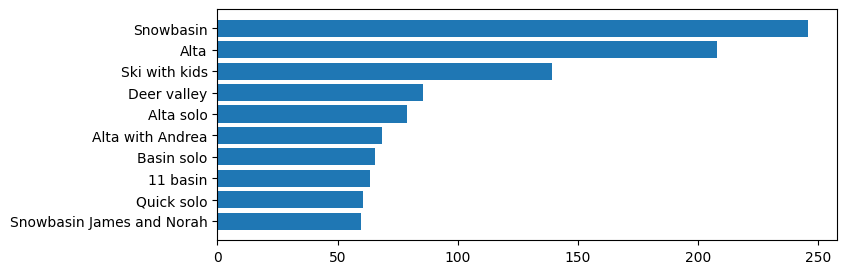

In [55]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 3))
distances = (tweak_strava(raw)
    .group_by('name')
    .agg(pl.sum('distance_2d').alias('distance_2d'))
    .with_columns(distance_miles=meters_to_miles(pl.col('distance_2d')))
    .select(['name', 'distance_2d', 'distance_miles'])

    .sort('distance_miles')
    .tail(10)
)

ax.barh(distances['name'], distances['distance_miles'])

## Master Aggregation

In [56]:
# distance per activity

(tweak_strava(raw_lazy)
    .group_by('id')
    .agg(
        activity=pl.col('name').first(),
        distance=pl.col('distance_2d').sum(),
        elevation=pl.col('elevation').sum(),
        elapsed=pl.col('elapsed').last(),
        period=pl.col('period').last(),
    )
    .with_columns(speed=pl.col('distance') / pl.col('elapsed'))
    .sort('distance')
    .collect()
    )

id,activity,distance,elevation,elapsed,period,speed
i64,cat,f32,f32,i32,duration[μs],f64
10074773869,"""Green canyon Ride (top loop is…",55.791634,7886.899902,3,3s,18.597211
4861795818,"""16 inches and forgot to record""",110.950768,16022.299805,10,10s,11.095077
11265245273,"""Popperton""",354.114624,316551.0625,211,3m 31s,1.678268
6941918314,"""6 person tandem""",1908.935547,5257.277344,1065,17m 45s,1.792428
5896404314,"""Rambler to ramble on lollipop.…",2233.667236,1.0373e6,721,12m 1s,3.098013
…,…,…,…,…,…,…
11045571812,"""28 Brighton""",78870.984375,4.95843e7,19146,5h 19m 6s,4.11945
1424403237,"""Alta with Andrea""",84568.515625,1.8253564e7,16758,4h 39m 18s,5.046456
3128639607,"""Quick solo""",97783.789062,4856241.5,4625,1h 17m 5s,21.142441


In [57]:
# filter > 23 hours

print(tweak_strava(raw_lazy)
    .group_by('id')
    .agg(
        activity=pl.col('name').first(),
        distance=pl.col('distance_2d').sum(),
        elevation=pl.col('elevation').sum(),
        elapsed=pl.col('elapsed').last(),
        period=pl.col('period').last(),
    )
    .with_columns(speed=pl.col('distance') / pl.col('elapsed'))
    .sort('elapsed')
    .filter(pl.col('elapsed') < 23 * 60 * 60)
    .collect()
    )

shape: (480, 7)
┌─────────────┬─────────────────┬──────────────┬──────────────┬─────────┬──────────────┬───────────┐
│ id          ┆ activity        ┆ distance     ┆ elevation    ┆ elapsed ┆ period       ┆ speed     │
│ ---         ┆ ---             ┆ ---          ┆ ---          ┆ ---     ┆ ---          ┆ ---       │
│ i64         ┆ cat             ┆ f32          ┆ f32          ┆ i32     ┆ duration[μs] ┆ f64       │
╞═════════════╪═════════════════╪══════════════╪══════════════╪═════════╪══════════════╪═══════════╡
│ 10074773869 ┆ Green canyon    ┆ 55.791634    ┆ 7886.899902  ┆ 3       ┆ 3s           ┆ 18.597211 │
│             ┆ Ride (top loop  ┆              ┆              ┆         ┆              ┆           │
│             ┆ is…             ┆              ┆              ┆         ┆              ┆           │
│ 4861795818  ┆ 16 inches and   ┆ 110.950768   ┆ 16022.299805 ┆ 10      ┆ 10s          ┆ 11.095077 │
│             ┆ forgot to       ┆              ┆              ┆         ┆  

In [58]:
# plot
(tweak_strava(raw_lazy)
    .group_by('id')
    .agg(
        activity=pl.col('name').first(),
        distance=pl.col('distance_2d').sum(),
        elevation=pl.col('elevation').sum(),
        elapsed=pl.col('elapsed').last(),
        period=pl.col('period').last(),
    )
    .with_columns(speed=pl.col('distance') / pl.col('elapsed'))
    .filter(pl.col('elapsed') < 23 * 60 * 60)
    .sort('distance')
    .tail(20)
    .collect()
    .select([pl.col('activity').cast(pl.Utf8), 'distance', ])
    .sort('distance')
    .plot.bar(y='activity', x='distance')
    )

alt.Chart(...)

:Bars   [activity]   (distance)
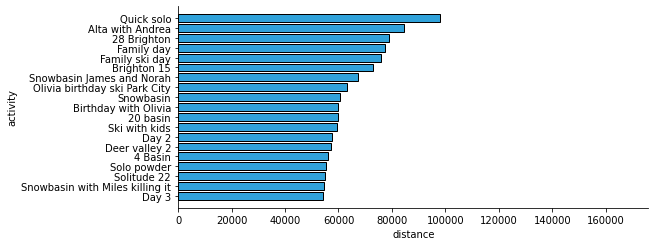

In [59]:
import matplotlib.pyplot as plt
import hvplot.polars
import hvplot
hvplot.extension('matplotlib')
fig, ax = plt.subplots(figsize=(6,4), dpi=300)
# plot
(tweak_strava(raw_lazy)
    .group_by('id')
    .agg(
        activity=pl.col('name').first(),
        distance=pl.col('distance_2d').sum(),
        elevation=pl.col('elevation').sum(),
        elapsed=pl.col('elapsed').last(),
        period=pl.col('period').last(),
    )
    .with_columns(speed=pl.col('distance') / pl.col('elapsed'))
    .filter(pl.col('elapsed') < 23 * 60 * 60)
    .sort('distance')
    
    .tail(20)
    .collect()
    .select([pl.col('activity').cast(pl.Utf8), 'distance', ])
    .hvplot.barh(x='activity', y='distance')
    )


In [60]:
# common aggregation - value counts
with pl.Config(set_tbl_rows=20):
    display(tweak_strava(raw_lazy)
    .select(pl.col('type').value_counts())
    .collect()
    )

type
struct[2]
"{""ebikeride"",433738}"
"{""cycling"",784828}"
"{""AlpineSki"",2227436}"


In [61]:
# use unnest to get the values out of the struct
with pl.Config(set_tbl_rows=20):
    display(tweak_strava(raw_lazy)
    .select(pl.col('type').value_counts())
    .collect()
    .unnest('type')
    )

type,count
cat,u32
"""ebikeride""",433738
"""cycling""",784828
"""AlpineSki""",2227436


In [62]:
# how far have I biked each year?
(tweak_strava(raw_lazy)
  .filter(pl.col('type').is_in(['ebikeride', 'cycling']))
  .group_by([pl.col('time').dt.year().alias('year'), 'type'])
  .agg(
      distance=pl.col('distance_2d').sum(),
  )
  .collect()
)


year,type,distance
i32,cat,f32
2024,"""cycling""",117095.242188
2024,"""ebikeride""",1.3035e6
2022,"""cycling""",479097.40625
2023,"""cycling""",443997.875
2019,"""cycling""",14222.912109
…,…,…
2023,"""ebikeride""",78663.265625
2017,"""cycling""",5572.508301
2016,"""cycling""",26981.732422


In [63]:
# pivot type
(tweak_strava(raw_lazy)
  .filter(pl.col('type').is_in(['ebikeride', 'cycling']))
    .group_by([pl.col('time').dt.year().alias('year'), 'type'])
    .agg(
        distance=pl.col('distance_2d').sum(),
    )
    .pivot(index='year', on='type')
    .collect()
)


AttributeError: 'LazyFrame' object has no attribute 'pivot'

In [65]:
# pivot type
(tweak_strava(raw_lazy)
  .filter(pl.col('type').is_in(['ebikeride', 'cycling']))
    .group_by([pl.col('time').dt.year().alias('year'), 'type'])
    .agg(
        distance=pl.col('distance_2d').sum(),
    )
    .collect()
    .pivot(index='year', on='type')
    )


year,ebikeride,cycling
i32,f32,f32
2024,1.3035e6,117095.242188
2023,78663.265625,443997.875
2016,null,26981.732422
2021,null,413450.9375
2020,null,668791.9375
2019,null,14222.912109
2018,null,5883.088379
2017,null,5572.508301
2022,null,479097.40625


In [66]:
# sort year (remember that Polars is multi-threaded)
(tweak_strava(raw_lazy)
  .filter(pl.col('type').is_in(['ebikeride', 'cycling']))
    .group_by([pl.col('time').dt.year().alias('year'), 'type'])
    .agg(
        distance=pl.col('distance_2d').sum(),
    )
    .collect()
    .pivot(index='year', on='type')
    .sort('year')
    )


year,cycling,ebikeride
i32,f32,f32
2016,26981.732422,null
2017,5572.508301,null
2018,5883.088379,null
2019,14222.912109,null
2020,668791.9375,null
2021,413450.9375,null
2022,479097.40625,null
2023,443997.875,78663.265625
2024,117095.242188,1.3035e6


:NdOverlay   [Variable]
   :Curve   [year]   (value)
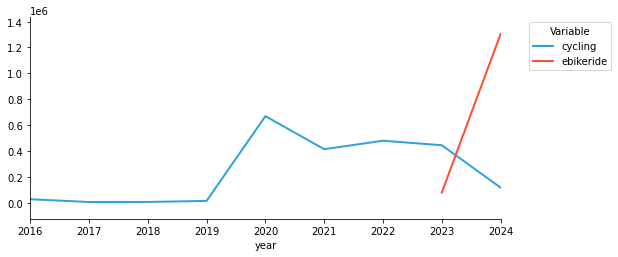

In [67]:
# plot
(tweak_strava(raw_lazy)
  .filter(pl.col('type').is_in(['ebikeride', 'cycling']))
    .group_by([pl.col('time').dt.year().alias('year'), 'type'])
    .agg(
        distance=pl.col('distance_2d').sum(),
    )
    .collect()
    .pivot(index='year', on='type')
    .sort('year')
    .hvplot.line(x='year', y=['cycling', 'ebikeride'])
    )


/var/folders/wh/trfsrmyd17z7vfjddf8z5jt00000gn/T/ipykernel_13258/1592474432.py:7: DeprecationWarning: The argument `by` for `LazyFrame.group_by_dynamic` is deprecated. It has been renamed to `group_by`.
  .group_by_dynamic(index_column='time', every='1w', by='type')


:NdOverlay   [Variable]
   :Curve   [time]   (value)
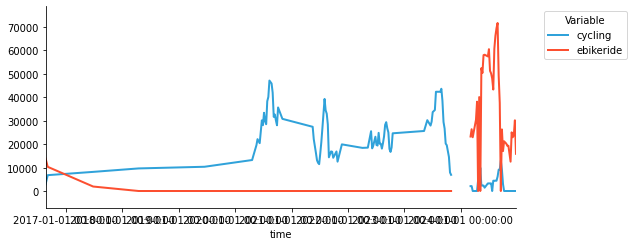

In [68]:
# Do weekly instead of yearly with .group_by_dynamic
# then add a rolling mean
(tweak_strava(raw_lazy)
  .filter(pl.col('type').is_in(['ebikeride', 'cycling']))
  .sort('time')
    #.group_by([pl.col('time').dt.year().alias('year'), 'type'])
    .group_by_dynamic(index_column='time', every='1w', by='type')
    .agg(
        distance=pl.col('distance_2d').sum(),
    )
    .collect()
    .pivot(index='time', on='type')
    # rolling mean
    .with_columns(
        cycling=pl.col('cycling')
        .fill_null(0)
        .rolling_mean(window_size=4),
        ebikeride=pl.col('ebikeride')
        .fill_null(0)
        .rolling_mean(window_size=4),
    )
    .sort('time')
    .hvplot.line(x='time', y=['cycling', 'ebikeride'])
    )


# Exercise: Aggregation

- Create a column *elevation_gained* that calculates the growth of elevation over an activity. (hint: use `.over`)
- What is the average *elevation_gained* for each *year*?
- What is the monthly distance for each *year*?
- What is the monthly distance for each *year* and activity type?

## Conclusion

* Correct types save space and enable convenient math, string, and date functionality
* Chaining operations will:
   * Make code readable
   * Remove bugs
   * Easier to debug
* ``.map_elements`` is slow for math
* Aggregations are powerful. Play with them until they make sense


Let's connect! Reach out (email, LinkedIn) if your team needs help with the Python data stack.

## Pandas Comparison

In [69]:
import pandas as pd

# Define column lists

def tweak_strava_pd(df: pd.DataFrame) -> pd.DataFrame:
    float_cols = ['distance_2d', 'latitude', 'longitude', 'elevation', 'speed_between']
    cat_cols   = ['name', 'type', 'filename']
    cols       = ['course', 'distance_2d', 'latitude', 'longitude', 'time', 'elevation',
                'speed_between', 'name', 'type', 'filename']
    final_cols = ['distance_2d', 'latitude', 'longitude', 'time', 'elevation', 'speed_between',
                'name', 'type', 'filename', 'id', 'elapsed', 'period']

    return (
        df
        .loc[:, cols]
        .assign(
            # Create 'id' from the filename by splitting, taking the last piece,
            # removing '.gpx', and converting to int64.
            id=lambda d: d['filename']
                .str.split('/')
                .str[-1]
                .str.replace('.gpx', '', regex=False)
                .astype('int64')
        )
        .assign(
            # Cast float_cols to float32.
            **{col: (lambda d, col=col: d[col].astype('float32')) for col in float_cols}
        )
        .assign(
            # Cast cat_cols to categorical dtype.
            **{col: (lambda d, col=col: d[col].astype('category')) for col in cat_cols}
        )
        .assign(
            # Convert the 'time' column to the 'America/Denver' timezone.
            time=lambda d: d['time'].dt.tz_convert('America/Denver')
        )
        .assign(
            # Compute 'elapsed': difference in seconds from the minimum time per 'id'.
            elapsed=lambda d: d.groupby('id')['time']
                               .transform(lambda x: (x - x.min()).dt.total_seconds())
                               .astype('int32')
        )
        .assign(
            # Compute 'period': time difference from the first time in each 'id' group.
            period=lambda d: d.groupby('id')['time']
                              .transform(lambda x: x - x.iloc[0])
        )
        [final_cols]
    )

# Example usage:
raw_pd = pd.read_parquet('data/bikeski.parquet')
tweak_strava_pd(raw_pd)



,distance_2d,latitude,longitude,time,elevation,speed_between,name,type,filename,id,elapsed,period
0,0.000000,41.370804,-111.901772,2024-06-29 10:54:56-06:00,1713.000000,NaN,365 and spork,ebikeride,data/activities/11769838026.gpx,11769838026,0,0 days 00:00:00
1,6.704555,41.370846,-111.901711,2024-06-29 10:54:57-06:00,1712.900024,6.705301,365 and spork,ebikeride,data/activities/11769838026.gpx,11769838026,1,0 days 00:00:01
2,4.160126,41.370808,-111.901718,2024-06-29 10:54:58-06:00,1712.800049,4.161328,365 and spork,ebikeride,data/activities/11769838026.gpx,11769838026,2,0 days 00:00:02
3,2.626280,41.370785,-111.901726,2024-06-29 10:54:59-06:00,1712.800049,2.626280,365 and spork,ebikeride,data/activities/11769838026.gpx,11769838026,3,0 days 00:00:03
4,1.269290,41.370773,-111.901733,2024-06-29 10:55:00-06:00,1712.699951,1.273223,365 and spork,ebikeride,data/activities/11769838026.gpx,11769838026,4,0 days 00:00:04
...,...,...,...,...,...,...,...,...,...,...,...,...
3445997,0.000000,40.747425,-111.562042,2021-07-08 19:52:18-06:00,1918.400024,0.000000,The dropout,cycling,data/activities/5597638888.gpx,5597638888,6804,0 days 01:53:24
3445998,0.139658,40.747425,-111.562042,2021-07-08 19:52:19-06:00,1918.400024,0.139658,The dropout,cycling,data/activities/5597638888.gpx,5597638888,6805,0 days 01:53:25
3445999,0.084335,40.747425,-111.562050,2021-07-08 19:52:20-06:00,1918.400024,0.084335,The dropout,cycling,data/activities/5597638888.gpx,5597638888,6806,0 days 01:53:26
3446000,0.168670,40.747425,-111.562050,2021-07-08 19:52:22-06:00,1918.400024,0.084335,The dropout,cycling,data/activities/5597638888.gpx,5597638888,6808,0 days 01:53:28


In [70]:
%%time
limit = 23 * 60 * 60  # 23 hours in seconds

(tweak_strava_pd(raw_pd)
    .groupby('id')
    .agg(
        activity=('name', 'first'),
        distance=('distance_2d', 'sum'),
        elevation=('elevation', 'sum'),
        elapsed=('elapsed', 'last'),
        period=('period', 'last')
    )
    .assign(speed=lambda df: df['distance'] / df['elapsed'])
    .sort_values('elapsed')
    .query("elapsed < @limit")
)

CPU times: user 10 s, sys: 1.39 s, total: 11.4 s
Wall time: 11.7 s


,activity,distance,elevation,elapsed,period,speed
id,,,,,,
10074773869,Green canyon Ride (top loop isn't too rideable),55.791634,7.886900e+03,3,0 days 00:00:03,18.597211
4861795818,16 inches and forgot to record,110.950775,1.602230e+04,10,0 days 00:00:10,11.095078
11265245273,Popperton,354.114777,3.165511e+05,211,0 days 00:03:31,1.678269
5896404314,Rambler to ramble on lollipop. (Do this one ag...,2233.667969,1.037280e+06,721,0 days 00:12:01,3.098014
12988205925,Muddy tunnel springs,2872.385742,1.341568e+06,894,0 days 00:14:54,3.212959
...,...,...,...,...,...,...
8506265385,Deer Valley 20,43060.558594,5.952812e+07,24158,0 days 06:42:38,1.782455
10391468275,Deer valley 2,57012.613281,5.504370e+07,24570,0 days 06:49:30,2.320416
835521326,Snowbasin,60681.773438,1.422902e+07,24727,0 days 06:52:07,2.454069
